In [ ]:
!pip3 install -q librosa tensorflow
!pip3 install llvmlite==0.31.0 -q
!pip3 install resampy -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.58.1 requires llvmlite<0.42,>=0.41.0dev0, but you have llvmlite 0.31.0 which is incompatible.


In [ ]:
!pip3 install kaggle -q

In [ ]:
import librosa
%matplotlib inline
import matplotlib.pyplot as plt
import librosa.display
from IPython.display import Audio
import numpy as np
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
from sklearn.metrics import confusion_matrix
import IPython.display as ipd  # To play sound in the notebook
import os # interface with underlying OS that python is running on
import sys
import warnings
# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from tensorflow.keras.regularizers import l2
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

### Random example wave plot

In [ ]:
x, sr = librosa.load('audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav')

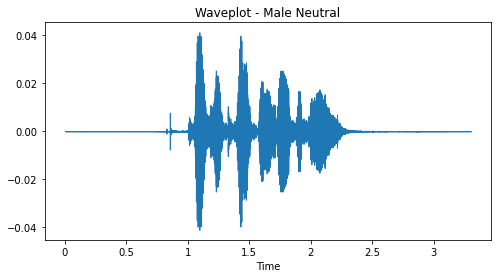

In [ ]:
import librosa.display
plt.figure(figsize=(8, 4))
librosa.display.waveshow(x, sr=sr)
plt.title('Waveplot - Male Neutral')
plt.savefig('Waveplot_MaleNeutral.png')

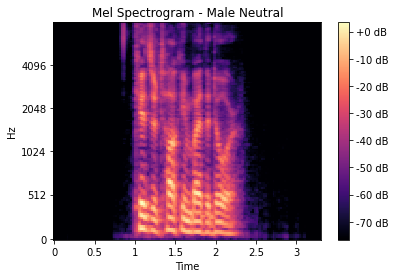

In [ ]:
spectrogram = librosa.feature.melspectrogram(y=x, sr=sr, n_mels=128,fmax=8000) 
spectrogram = librosa.power_to_db(spectrogram)

librosa.display.specshow(spectrogram, y_axis='mel', fmax=8000, x_axis='time');
plt.title('Mel Spectrogram - Male Neutral')
plt.savefig('MelSpec_MaleNeutral.png')
plt.colorbar(format='%+2.0f dB')

### Data Reading

In [ ]:
audio_parent_folder = "audio_speech_actors_01-24/"
actor_all_folders = os.listdir(audio_parent_folder)
actor_all_folders.sort()

In [ ]:
emotion = []
gender = []
actor = []
full_file_path = []
for item in actor_all_folders:
    wave_folder = "audio_speech_actors_01-24/" + item
    wave_files = os.listdir(wave_folder)
    for filename in wave_files:
        part = filename.split('.')[0].split('-')
        emotion.append(int(part[2]))
        actor.append(int(part[6]))
        bg = int(part[6])
        gender_mf = "female" if bg%2 == 0 else "male"
        gender.append(gender_mf)
        full_file_path.append("audio_speech_actors_01-24/" + item + '/' + filename)

In [ ]:
emotion_df = pd.DataFrame({'emotion': emotion, 'gender': gender, 'actor': actor, 'filepath': full_file_path})
mapping = {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}
emotion_df['emotion'] = emotion_df['emotion'].map(mapping)
emotion_df.head(100)

,emotion,gender,actor,filepath
0,disgust,male,1,audio_speech_actors_01-24/Actor_01/03-01-07-01...
1,angry,male,1,audio_speech_actors_01-24/Actor_01/03-01-05-02...
2,happy,male,1,audio_speech_actors_01-24/Actor_01/03-01-03-01...
3,fear,male,1,audio_speech_actors_01-24/Actor_01/03-01-06-01...
4,fear,male,1,audio_speech_actors_01-24/Actor_01/03-01-06-02...
...,...,...,...,...
95,fear,female,2,audio_speech_actors_01-24/Actor_02/03-01-06-01...
96,neutral,female,2,audio_speech_actors_01-24/Actor_02/03-01-01-01...
97,angry,female,2,audio_speech_actors_01-24/Actor_02/03-01-05-01...
98,happy,female,2,audio_speech_actors_01-24/Actor_02/03-01-03-02...


### Exploratory Data Analysis

<AxesSubplot:>

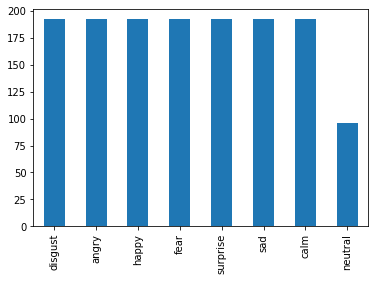

In [ ]:
emotion_df['emotion'].value_counts().plot(kind='bar')

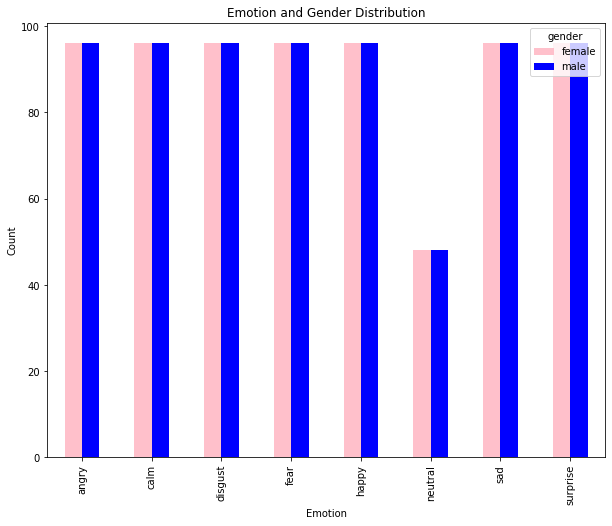

In [ ]:
def plot_distribution(df): 
    countTable = df.groupby(['emotion', 'gender']).count()
    pivotTable = countTable.pivot_table(index='emotion', columns='gender', values='filepath')

    pivotTable.plot(kind='bar', figsize=(10, 8), color=['pink', 'blue'])
    plt.title('Emotion and Gender Distribution')
    plt.xlabel('Emotion')
    plt.ylabel('Count')
    plt.show()
    
plot_distribution(emotion_df)

### Feature Engineering

In [ ]:
def getFeatures(signal, sample_rate):    
    spectrogram = librosa.feature.melspectrogram(y = signal, sr=sample_rate, n_mels=128,fmax=8000) 
    db_spec = librosa.power_to_db(spectrogram)
    log_spectrogram = np.mean(db_spec, axis = 0) 
    mfcc = librosa.feature.mfcc(y = signal, sr=sample_rate, n_mfcc=13)
    mfcc=np.mean(mfcc,axis=0) # Mel-frequency cepstral coefficients (MFCCs)
    chroma = librosa.feature.chroma_stft(y = signal, sr=sample_rate)
    chroma = np.mean(chroma, axis = 0) # compute chroma energy (pertains to 12 different pitch classes)
    contrast = librosa.feature.spectral_contrast(y = signal, sr=sample_rate)
    contrast = np.mean(contrast, axis= 0) # compute spectral contrast
    zcr = librosa.feature.zero_crossing_rate(y = signal)
    zcr = np.mean(zcr, axis= 0)
    #print(np.concatenate((np.array(log_spectrogram).reshape(1, -1), np.array(mfcc).reshape(1, -1)), axis = 1).shape)
    #print(np.array(mfcc).reshape(1, -1).shape)
    #print(np.array(log_spectrogram).reshape(1, -1).shape)
    interm1 = np.concatenate((np.array(log_spectrogram).reshape(1, -1), np.array(mfcc).reshape(1, -1)), axis = 1)
    interm2 = np.concatenate((interm1, np.array(chroma).reshape(1, -1)), axis = 1)
    final = np.concatenate((interm2, np.array(zcr).reshape(1, -1)), axis = 1)
    return final

In [ ]:
from tqdm import tqdm
full_data_df = pd.DataFrame(columns=['features'])
cnt = 0
for path in tqdm(emotion_df.filepath):
    signal, sample_rate = librosa.load(path, res_type='kaiser_fast', duration=3, sr=44100, offset=0.5)
    features = getFeatures(signal, sample_rate)
    full_data_df.loc[cnt] = [features.tolist()[0]]
    cnt = cnt + 1

100%|██████████| 1440/1440 [01:42<00:00, 14.02it/s]


In [ ]:
full_data_df.head(10)

,features
0,"[-79.49121856689453, -79.49121856689453, -79.4..."
1,"[-46.18931579589844, -46.15364456176758, -46.1..."
2,"[-74.08995056152344, -74.08995056152344, -74.0..."
3,"[-60.80644226074219, -64.12113189697266, -67.1..."
4,"[-50.86897659301758, -48.946651458740234, -48...."
5,"[-71.20063018798828, -71.20063018798828, -71.2..."
6,"[-76.38516998291016, -76.38516998291016, -76.3..."
7,"[-65.4364013671875, -65.4364013671875, -65.436..."
8,"[-74.44441986083984, -74.44441986083984, -74.4..."
9,"[-76.47003936767578, -76.47003936767578, -76.4..."


In [ ]:
df_combined = pd.concat([emotion_df, pd.DataFrame(full_data_df['features'].values.tolist())],axis=1)
df_combined = df_combined.fillna(0)

In [ ]:
df_combined.drop(columns='filepath',inplace=True)

In [ ]:
df_combined.head()

,emotion,gender,actor,0,1,2,3,4,5,6,...,1026,1027,1028,1029,1030,1031,1032,1033,1034,1035
0,disgust,male,1,-79.491219,-79.491219,-79.491219,-79.491219,-79.491219,-79.491219,-79.491219,...,0.591797,0.541016,0.395508,0.287109,0.166992,0.127930,0.130371,0.093262,0.075195,0.048340
1,angry,male,1,-46.189316,-46.153645,-46.149235,-46.002964,-45.773327,-45.375832,-45.463463,...,0.048340,0.045898,0.047852,0.039551,0.036133,0.039062,0.037109,0.036133,0.027832,0.014160
2,happy,male,1,-74.089951,-74.089951,-74.084686,-74.089951,-74.089951,-74.089951,-74.075119,...,0.089844,0.145508,0.193359,0.191406,0.209961,0.200684,0.267090,0.314453,0.277344,0.199219
3,fear,male,1,-60.806442,-64.121132,-67.123573,-66.897316,-66.791481,-66.575943,-66.172562,...,0.241211,0.198242,0.224121,0.261719,0.261719,0.277344,0.187988,0.227539,0.240234,0.158203
4,fear,male,1,-50.868977,-48.946651,-48.975761,-48.741577,-48.503746,-48.285763,-48.010662,...,0.046387,0.056152,0.061035,0.068359,0.057617,0.053711,0.050781,0.042480,0.026855,0.017090


In [ ]:
train, testv = train_test_split(df_combined, test_size=0.3, random_state=0, stratify=df_combined[['emotion','gender','actor']])
valid, test = train_test_split(testv, test_size=0.66, random_state=0)

In [ ]:
def preprocess(data):
    X_data = data.iloc[:, 3:]
    y_data = data.iloc[:, :2].drop(columns=['gender'])
    return X_data, y_data
X_train, y_train = preprocess(train)
print(X_train.shape)

(1008, 1036)


In [ ]:
X_test, y_test = preprocess(test)
X_valid, y_valid = preprocess(valid)
print(X_valid.shape)

(146, 1036)


In [ ]:
def standardise(data, mean, std):
    X_data = (data - mean)/std
    return np.array(X_data)[:,:,np.newaxis]

mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = standardise(X_train, mean, std)
X_test = standardise(X_test, mean, std)
X_valid = standardise(X_valid, mean, std)

In [ ]:
lb = LabelEncoder()
y_train = to_categorical(lb.fit_transform(np.array(y_train)))
y_test = to_categorical(lb.fit_transform(np.array(y_test)))
y_valid = to_categorical(lb.fit_transform(np.array(y_valid)))

In [ ]:
print(lb.classes_)

['angry' 'calm' 'disgust' 'fear' 'happy' 'neutral' 'sad' 'surprise']


In [ ]:
#X_train = X_train[:,:,np.newaxis]
#X_test = X_test[:,:,np.newaxis]
#X_valid = X_valid[:,:,np.newaxis]

X_train.shape

(1008, 1036, 1)

In [ ]:
X_test.shape

(286, 1036, 1)

In [ ]:
X_train.shape

(1008, 1036, 1)

### Convolutional Neural Network Model Development

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model

#BUILD 1D CNN LAYERS

def create_cnn(number_cnn, output_nodes, p):
    model = tf.keras.Sequential()
    model.add(layers.Conv1D(64, kernel_size=(10), activation='relu', input_shape=(X_train.shape[1],1)))
    model.add(layers.Dropout(p))
    model.add(layers.Conv1D(128, kernel_size=(10),activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
    model.add(layers.MaxPooling1D(pool_size=(8)))
    model.add(layers.Dropout(p))
    for i in range(number_cnn-2):
        model.add(layers.Conv1D(128, kernel_size=(10),activation='relu'))
        model.add(layers.Dropout(p))
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(p))
    model.add(layers.Dense(output_nodes, activation='sigmoid'))
    return model

output_nodes = 8
p = 0.5
number_cnn = 7
model = create_cnn(number_cnn, output_nodes, p)
opt = keras.optimizers.Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_14 (Conv1D)          (None, 1027, 64)          704       
                                                                 
 dropout_16 (Dropout)        (None, 1027, 64)          0         
                                                                 
 conv1d_15 (Conv1D)          (None, 1018, 128)         82048     
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 127, 128)          0         
 g1D)                                                            
                                                                 
 dropout_17 (Dropout)        (None, 127, 128)          0         
                                                                 
 conv1d_16 (Conv1D)          (None, 118, 128)          163968    
                                                      

### Model Training

In [ ]:
import tensorflow.keras as keras

# FIT MODEL AND USE CHECKPOINT TO SAVE BEST MODEL
checkpoint = ModelCheckpoint("best_initial_model.hdf5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max', period=1, save_weights_only=True)

model_history=model.fit(X_train, y_train,batch_size=32, epochs=40, validation_data=(X_valid, y_valid),callbacks=[checkpoint])

Epoch 1/40
32/32 [==============================] - ETA: 0s - loss: 2.8075 - accuracy: 0.1419
Epoch 1: val_accuracy improved from -inf to 0.14384, saving model to best_initial_model.hdf5
32/32 [==============================] - 5s 100ms/step - loss: 2.8075 - accuracy: 0.1419 - val_loss: 2.5734 - val_accuracy: 0.1438
Epoch 2/40
32/32 [==============================] - ETA: 0s - loss: 2.3740 - accuracy: 0.1855
Epoch 2: val_accuracy improved from 0.14384 to 0.25342, saving model to best_initial_model.hdf5
32/32 [==============================] - 3s 91ms/step - loss: 2.3740 - accuracy: 0.1855 - val_loss: 2.2611 - val_accuracy: 0.2534
Epoch 3/40
32/32 [==============================] - ETA: 0s - loss: 2.1285 - accuracy: 0.2143
Epoch 3: val_accuracy did not improve from 0.25342
32/32 [==============================] - 3s 93ms/step - loss: 2.1285 - accuracy: 0.2143 - val_loss: 2.0357 - val_accuracy: 0.2534
Epoch 4/40
31/32 [============================>.] - ETA: 0s - loss: 2.0334 - accuracy: 

### Accuracy and Loss Graph over the epochs

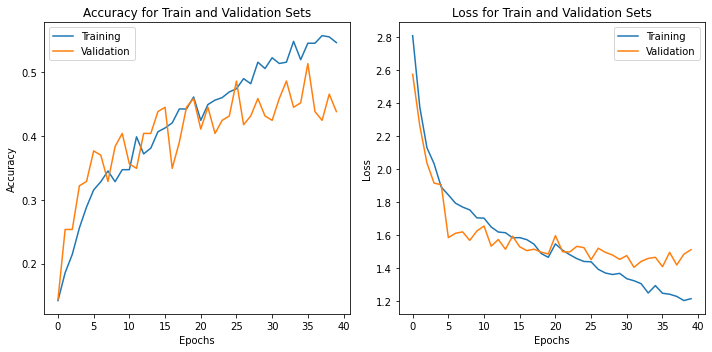

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].plot(model_history.history['accuracy'])
axes[0].plot(model_history.history['val_accuracy'])
axes[0].set_title('Accuracy for Train and Validation Sets')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epochs')
axes[0].legend(['Training', 'Validation'])

axes[1].plot(model_history.history['loss'])
axes[1].plot(model_history.history['val_loss'])
axes[1].set_title('Loss for Train and Validation Sets')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epochs')
axes[1].legend(['Training', 'Validation'])

fig.tight_layout()

plt.show()

### Evaluation: Test data loss and accuracy 

In [ ]:
(loss, accuracy) = model.evaluate(X_test,y_test)
print(str(loss) + " & "+ str(accuracy))

9/9 [==============================] - 0s 21ms/step - loss: 1.5500 - accuracy: 0.4650
1.5499861240386963 & 0.46503496170043945


### Evaluation: Test data Groud Truth and Class Prediction

In [ ]:
def logit_transformation(y_predict):
    return (lb.inverse_transform((y_predict.argmax(axis=1).astype(int).flatten())))

y_pred = model.predict(X_test)
y_pred = logit_transformation(y_pred)
y_pred = pd.DataFrame({'Predicted Values': y_pred})

y_true = logit_transformation(y_test)
y_true = pd.DataFrame({'True Values': y_true})

finaldf = y_true.join(y_pred)
finaldf[150:160]

9/9 [==============================] - 0s 21ms/step


,True Values,Predicted Values
150,angry,sad
151,surprise,sad
152,surprise,surprise
153,calm,calm
154,sad,sad
155,disgust,disgust
156,surprise,surprise
157,happy,fear
158,disgust,disgust
159,sad,calm


In [ ]:
emotion_list = ['angry','calm','disgust','fear','happy','neutral','sad','surprise']

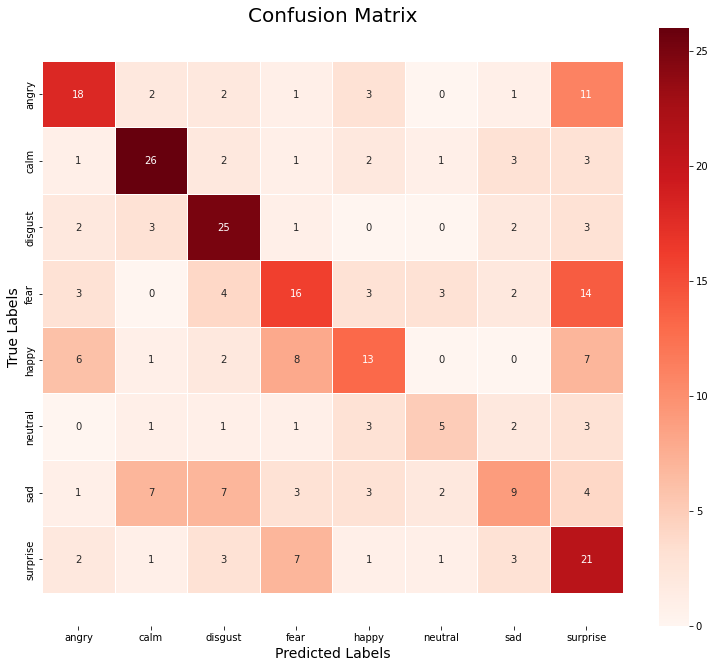

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (13, 11))
cm = pd.DataFrame(cm , index = emotion_list , columns = emotion_list)
ax = sns.heatmap(cm, linecolor='white', cmap='Reds', linewidth=1, annot=True, fmt='')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('True Labels', size=14)
plt.savefig('Confusion_Matrix.png')
plt.show()


In [ ]:
print(classification_report(y_true, y_pred, target_names = emotion_list))


              precision    recall  f1-score   support

       angry       0.55      0.47      0.51        38
        calm       0.63      0.67      0.65        39
     disgust       0.54      0.69      0.61        36
        fear       0.42      0.36      0.39        45
       happy       0.46      0.35      0.40        37
     neutral       0.42      0.31      0.36        16
         sad       0.41      0.25      0.31        36
    surprise       0.32      0.54      0.40        39

    accuracy                           0.47       286
   macro avg       0.47      0.46      0.45       286
weighted avg       0.47      0.47      0.46       286

